# Named entity recognition pipline for russian language with Rubert-Tiny model.

In [2]:
!pip install transformers

In [3]:
#import libraries
import os
import pandas as pd
from time import time
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, RandomSampler, SequentialSampler
import transformers
from transformers import BertConfig, BertForTokenClassification, RobertaTokenizerFast, AutoModelForTokenClassification, AdamW, AutoTokenizer, get_linear_schedule_with_warmup, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score

In [4]:
transformers.__version__

'4.17.0'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#convert conllu dataset to csv
DATASET_SIZE = 3000000
start = time()
file_path = '/content/drive/MyDrive/NER/nerus_lenta.conllu' #path where your .conllu file is located
with open(file_path, 'r', encoding='utf-8') as file:
    file_prefix = file_path.split('.')[0] + '_'
    doc_id = ''
    sent_id = ''
    records = list()
    for idx, line in enumerate(file):
        if idx % 100000 == 0:
            print(idx)
        if idx == DATASET_SIZE:
            break
        if len(line) > 1 :
            if line[0] == '#':
                line = line.split('=')
                if 'newdoc' in line[0]:
                    doc_id = file_prefix + line[1].strip()
                elif 'sent_id' in line[0]:
                    sent_id = line[1].strip()
            else:
                info = line.split('\t')
                if len(info) == 10:
                    records.append([doc_id, sent_id] + [x.strip() for x in info])
end = time()
print("Time elapsed:", end-start, "seconds")

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
Time elapsed: 18.3066828250885 seconds


In [7]:
df = pd.DataFrame(records, columns=['DOC_NO', 'SENT_NO', 'ID', 'FORM','LEMMA','UPOS', 'XPOS', 'FEAT','HEAD', 'DEPREL', 'DEPS', 'MISC'])
#rename columns
df = df[['SENT_NO', 'FORM', 'UPOS', 'MISC']]
df.rename(columns={"SENT_NO":"sentence_id","FORM":"words","MISC":"Tag"}, inplace =True)
#clear 'Tag' column
l = lambda x: x.replace('Tag=', '')
df['Tag'] = df['Tag'].apply(l)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,sentence_id,words,UPOS,Tag
0,0_0,Вице-премьер,NOUN,O
1,0_0,по,ADP,O
2,0_0,социальным,ADJ,O
3,0_0,вопросам,NOUN,O
4,0_0,Татьяна,PROPN,B-PER


In [8]:
#create a new column called "sentence" which groups the words by sentence 
df['sentence'] = df[['sentence_id','words','Tag']].groupby(['sentence_id'])['words'].transform(lambda x: ' '.join(x))
#create a new column called "word_labels" which groups the tags by sentence 
df['word_labels'] = df[['sentence_id','words','Tag']].groupby(['sentence_id'])['Tag'].transform(lambda x: ','.join(x))
df.head()

,sentence_id,words,UPOS,Tag,sentence,word_labels
0,0_0,Вице-премьер,NOUN,O,Вице-премьер по социальным вопросам Татьяна Го...,"O,O,O,O,B-PER,I-PER,O,O,O,O,O,B-LOC,O,O,O,O,O,..."
1,0_0,по,ADP,O,Вице-премьер по социальным вопросам Татьяна Го...,"O,O,O,O,B-PER,I-PER,O,O,O,O,O,B-LOC,O,O,O,O,O,..."
2,0_0,социальным,ADJ,O,Вице-премьер по социальным вопросам Татьяна Го...,"O,O,O,O,B-PER,I-PER,O,O,O,O,O,B-LOC,O,O,O,O,O,..."
3,0_0,вопросам,NOUN,O,Вице-премьер по социальным вопросам Татьяна Го...,"O,O,O,O,B-PER,I-PER,O,O,O,O,O,B-LOC,O,O,O,O,O,..."
4,0_0,Татьяна,PROPN,B-PER,Вице-премьер по социальным вопросам Татьяна Го...,"O,O,O,O,B-PER,I-PER,O,O,O,O,O,B-LOC,O,O,O,O,O,..."


In [9]:
#create dictionaries
labels_to_ids = {k: v for v, k in enumerate(df.Tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(df.Tag.unique())}
labels_to_ids

{'B-LOC': 3,
 'B-ORG': 4,
 'B-PER': 1,
 'I-LOC': 6,
 'I-ORG': 5,
 'I-PER': 2,
 'O': 0}

In [10]:
#create data
data = df[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,word_labels
0,Вице-премьер по социальным вопросам Татьяна Го...,"O,O,O,O,B-PER,I-PER,O,O,O,O,O,B-LOC,O,O,O,O,O,..."
1,"По словам Голиковой , чаще всего онкологически...","O,O,B-PER,O,O,O,O,O,O,O,O,O,B-LOC,O,B-LOC,O,B-..."
2,"Вице-премьер напомнила , что главные факторы с...","O,O,O,O,O,O,O,O,B-LOC,O,O,O,O,O,O,O"
3,"В начале года стало известно , что смертность ...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,"По данным Росстата , в 2017 году от рака умерл...","O,O,B-ORG,O,O,O,O,O,O,O,O,O,O,O"


In [11]:
data.sentence[14][:300]

'Биатлонисту Антону Шипулину , также попавшему в список , полиция нанесла отдельный визит : сейчас он тренируется отдельно в австрийском Обертиллахе .'

In [12]:
print(len(data))
print(data.iloc[41].sentence)
print(data.iloc[41].word_labels)

131227
Согласно документам , в 2014 году Доннелли выдвинул ряд предложений британским властям в связи с ситуацией в Крыму .
O,O,O,O,O,O,B-PER,O,O,O,O,O,O,O,O,O,O,B-LOC,O


## Preparing dataloader

In [13]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")

In [14]:
dataset = {}
# all sentences list
sentences = list(data.sentence)
sentences = [sentence.split() for sentence in sentences]
# all labels list
labels = list(data.word_labels)
labels = [lable.split(',') for lable in labels]


MAX_LEN = 300

def labels_to_number(labeled_list: list, labels_to_ids: dict, max_length) -> list:
    """
    input: list of labels ['O','O','O','B-PER','I-PER','O','O','B-LOC']
    output: list of labels numbers [0, 0, 0, 1, ...] with padding
    """
    new_labels = [0 for _ in range(max_length)]
    labeled_list = labeled_list if len(labeled_list) <= max_length else labeled_list[:max_length]
    for idx in range(len(labeled_list)):
        new_labels[idx] = labels_to_ids[labeled_list[idx]]
    return new_labels

def tokenize(sentence: list, tokenizer, max_length):
    """
    input: one sentence ['some', 'sentence', 'here'];
    output: tokens_ids - tensor([1234, 23, 3241]), 
            attention_mask -  tensor([1, 1, 1, 1, 1, 1, 1, 1, 0,]),
            bert_tokens - ['what', 'both', 'al', 'pac', '##ino', 'and', 'robert', 'den'].
    """
    tokens_ids = []
    attention_mask = []
    bert_tokens = []
    tokenized_input = tokenizer(sentence,
                                add_special_tokens = True,
                                truncation = True,
                                max_length = max_length,           
                                pad_to_max_length = True,
                                return_attention_mask = True,   
                                return_tensors = 'pt',
                                is_split_into_words=True
                               )
    
    tokens_ids = tokenized_input['input_ids'][0]
    attention_mask = tokenized_input['attention_mask'][0]
    bert_tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"][0])
    return tokens_ids, attention_mask, bert_tokens


In [15]:
# lists of bert tokens
bert_tokens = []
#tokens ids
tokens_ids = []
# new int labels
new_labels = []
# attention masks
attentions_masks = []
# tokenize each sentence 
for sentence in sentences:
    token_id, attention_mask, bert_token = tokenize(sentence, tokenizer, MAX_LEN)
    tokens_ids.append(token_id)
    attentions_masks.append(attention_mask)
    bert_tokens.append(bert_token)
for label in labels:
    new_label = labels_to_number(label, labels_to_ids, MAX_LEN)
    new_labels.append(new_label)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
print("Bert tokens: ", bert_tokens[0])
print("Tokens ids: ", tokens_ids[0])
print("New labels: ", new_labels[0])
print("Attantion mask: ", attentions_masks[0])

Bert tokens:  ['[CLS]', 'В', '##ице', '-', 'премьер', 'по', 'со', '##циальным', 'вопросам', 'Татьяна', 'Г', '##оли', '##кова', 'р', '##ассказ', '##ала', ',', 'в', 'как', '##их', 'региона', '##х', 'России', 'за', '##фи', '##кс', '##ирован', '##а', 'наиболее', 'вы', '##сок', '##ая', 'см', '##ерт', '##ность', 'от', 'рака', ',', 'со', '##об', '##щает', 'Р', '##И', '##А', 'Ново', '##сти', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

## Convert input_ids, attentions_masks and new_labels to TensorDataset

In [17]:
pt_input_ids = torch.stack(tokens_ids, dim=0)

pt_attention_masks = torch.stack(attentions_masks, dim=0)

pt_labels = torch.tensor(new_labels, dtype=torch.long)

In [18]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

118,104 training samples
13,123 validation samples


In [20]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE)

print(type(train_dataset))

<class 'torch.utils.data.dataset.Subset'>


## Build model

In [21]:
model = AutoModelForTokenClassification.from_pretrained("cointegrated/rubert-tiny", num_labels=len(labels_to_ids.values()))
#model = AutoModel.from_pretrained("cointegrated/rubert-tiny", num_labels=len(labels_to_ids.values()))

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized f

## Training 

In [22]:
# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = 4e-5, # args.learning_rate 
                  eps = 1e-8 # args.adam_epsilon 
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [23]:
# Number of training epochs 
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
import random

model.to(device)

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    total_loss = 0

    model.train()
    
    for step, batch in enumerate(train_dataloader):
       
        if step % 100 == 0 and not step == 0:
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs[0]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("  Average training loss: {0:.5f}".format(avg_train_loss))

======== Epoch 1 / 10 ========
Training...
  Batch   100  of  1,846.
  Batch   200  of  1,846.
  Batch   300  of  1,846.
  Batch   400  of  1,846.
  Batch   500  of  1,846.
  Batch   600  of  1,846.
  Batch   700  of  1,846.
  Batch   800  of  1,846.
  Batch   900  of  1,846.
  Batch 1,000  of  1,846.
  Batch 1,100  of  1,846.
  Batch 1,200  of  1,846.
  Batch 1,300  of  1,846.
  Batch 1,400  of  1,846.
  Batch 1,500  of  1,846.
  Batch 1,600  of  1,846.
  Batch 1,700  of  1,846.
  Batch 1,800  of  1,846.
  Average training loss: 0.04
======== Epoch 2 / 10 ========
Training...
  Batch   100  of  1,846.
  Batch   200  of  1,846.
  Batch   300  of  1,846.
  Batch   400  of  1,846.
  Batch   500  of  1,846.
  Batch   600  of  1,846.
  Batch   700  of  1,846.
  Batch   800  of  1,846.
  Batch   900  of  1,846.
  Batch 1,000  of  1,846.
  Batch 1,100  of  1,846.
  Batch 1,200  of  1,846.
  Batch 1,300  of  1,846.
  Batch 1,400  of  1,846.
  Batch 1,500  of  1,846.
  Batch 1,600  of  1,846.


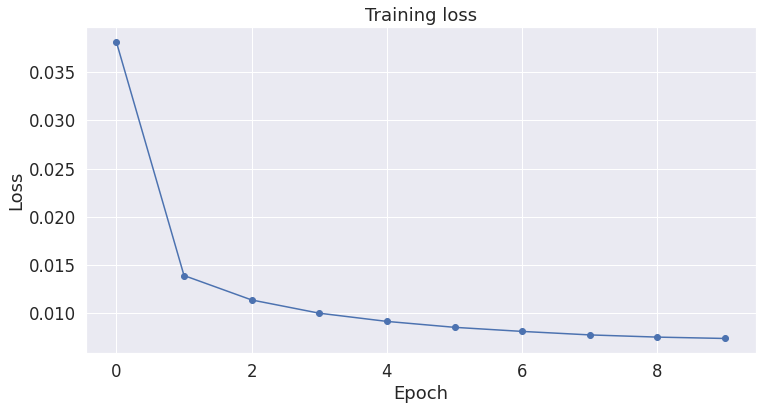

In [26]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [27]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch) ##t.to(device)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 

    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [28]:
# First, combine the results across the batches.
all_predictions = np.concatenate(predictions, axis=0)
all_true_labels = np.concatenate(true_labels, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels. 

# For each token, pick the label with the highest score.
predicted_label_ids = np.argmax(all_predictions, axis=2)

print("\nAfter choosing the highest scoring label for each token:")
print("    ", predicted_label_ids.shape) 


# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids = np.concatenate(predicted_label_ids, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

print("\nAfter flattening the sentences, we have predictions:")
print("    ", predicted_label_ids.shape)
print("and ground truth:")
print("    ", all_true_labels.shape)

After flattening the batches, the predictions have shape:
     (13123, 300, 7)

After choosing the highest scoring label for each token:
     (13123, 300)

After flattening the sentences, we have predictions:
     (3936900,)
and ground truth:
     (3936900,)


In [29]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions = []
real_token_labels = []

# For each of the input tokens in the dataset...
for i in range(len(all_true_labels)):

    # If it's not a token with a null label...
    if not all_true_labels[i] == -100:
        
        # Add the prediction and the ground truth to their lists.
        real_token_predictions.append(predicted_label_ids[i])
        real_token_labels.append(all_true_labels[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels)))
print(" After filtering out `null` tokens, length = {:,}".format(len(real_token_labels)))

Before filtering out `null` tokens, length = 3,936,900
 After filtering out `null` tokens, length = 3,936,900


In [30]:
from sklearn.metrics import f1_score

f1 = f1_score(real_token_labels, real_token_predictions, average='micro') 

print ("F1 score: {:.2%}".format(f1))

F1 score: 99.76%


In [1]:
accuracy_score(real_token_labels, real_token_predictions)

NameError: ignored

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(real_token_labels, real_token_predictions, average='micro'))
print(recall_score(real_token_labels, real_token_predictions))

In [38]:
test_sentence = input ("Enter number :") 

Enter number :На работе Енакентий евгеньевич украл кота


In [39]:
#Encoding and convert the sentences into tensors
sample_sentence = tokenizer.encode(test_sentence)
sample_input_ids = torch.tensor([sample_sentence]).cuda()

#Predicting the test data set using model() function
with torch.no_grad():
    output = model(sample_input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

#Function which retrieves key value for our Label Dictionary
def get_key(val):
    for key, value in labels_to_ids.items():
         if val == value:
             return key
 
    return "key doesn't exist"

#Tokenize  
tokens = tokenizer.convert_ids_to_tokens(sample_input_ids.to('cpu').numpy()[0])
new_tokens, new_label = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_label.append(get_key(label_idx))
        new_tokens.append(token)

#cheat
new_label = ['O'] + new_label[:-1]
#Appending Tokens and Labels
movie_token=[]
movie_label=[]
for token, label in zip(new_tokens, new_label):
    movie_token.append(token) 
    movie_label.append(label)

df=pd.DataFrame({"Token":movie_token,"Movie_Label":movie_label})
df.T

,0,1,2,3,4,5,6,7
Token,[CLS],На,работе,Енакентий,евгеньевич,украл,кота,[SEP]
Movie_Label,O,O,O,B-PER,O,O,O,O


In [41]:
torch.save(model.state_dict(), 'ner-model-best.pth')